In [1]:
import pandas as pd

afloramiento = pd.read_csv("../data/afloramientoFNMOC.csv")
nutrientes = pd.read_excel("../data/nut.J.Torres(02-12,16-18)def.xlsx")
pigmentos = pd.read_excel("../data/Pigmentos_UVigo.xlsx", sheet_name="Pigmentos_2002_2012")
pseudo_nitzschia = pd.read_excel("../data/Recuentos Pseudo-nitzschia sp. y Gymnodinium catenatum.xlsx", sheet_name="ALL")

In [2]:
ts_2002_2012 = pd.read_excel("../data/ts_2002_2012.xlsx")

In [3]:
ts_2002_2012.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [4]:
# Renombrar las columnas
ts_2002_2012.columns = ["Código", "Estacion", "Ría", "Data", "Temperatura", "CODVAL_0", "Salinidad", "CODVAL_1", "Profundidad", "CODVAL_2"]

# Mostrar las primeras filas para verificar
ts_2002_2012 = ts_2002_2012[['Código', "Data", "Temperatura", "Salinidad"]]
print(ts_2002_2012.head(1))

  Código                Data Temperatura Salinidad
0  A0    2012-01-30 15:24:00     13.3594   35.6573


In [5]:
ts_2002_2012['Código'].value_counts()

Código
A0       71286
P4       64797
V5       64311
M5       51715
P6       26332
V4       24824
A6       21113
M3       11841
Name: count, dtype: int64

In [6]:
# Asegurar que 'Data' es datetime
ts_2002_2012["Data"] = pd.to_datetime(ts_2002_2012["Data"])

# Extraer solo la fecha sin la hora
ts_2002_2012["Fecha"] = ts_2002_2012["Data"].dt.date

# Convertir Temperatura y Salinidad a numérico (por si tienen valores tipo string)
ts_2002_2012["Temperatura"] = pd.to_numeric(ts_2002_2012["Temperatura"], errors="coerce")
ts_2002_2012["Salinidad"] = pd.to_numeric(ts_2002_2012["Salinidad"], errors="coerce")

# Agrupar por 'Código' y 'Fecha', tomando la media solo de las columnas numéricas
ts_2002_2012 = ts_2002_2012.groupby(["Código", "Fecha"], as_index=False)[["Temperatura", "Salinidad"]].mean()

# Renombrar las columnas
ts_2002_2012.rename(columns={"Código": "STATION", "Fecha": "FECHA", "Temperatura":"TEMPERATURA", "Salinidad":"SALINIDAD"}, inplace=True)
ts_2002_2012["STATION"] = ts_2002_2012["STATION"].str.strip()
# Mostrar las primeras filas
print(ts_2002_2012.head())

  STATION       FECHA  TEMPERATURA  SALINIDAD
0      A0  2006-01-02    13.400782  35.608330
1      A0  2006-01-09    13.353843  35.648164
2      A0  2006-01-17    12.816960  35.532549
3      A0  2006-01-23    12.961577  35.566859
4      A0  2006-01-30    12.775529  35.650120


In [7]:
ts_2002_2012['STATION'].value_counts()

STATION
V4    302
V5    299
P6    297
A0    296
P4    296
A6    295
M5    251
M3    250
Name: count, dtype: int64

In [8]:
# Asegúrate de que la columna FECHA esté en formato datetime
ts_2002_2012['FECHA'] = pd.to_datetime(ts_2002_2012['FECHA'])

# Extraemos el año de la columna FECHA
ts_2002_2012['AÑO'] = ts_2002_2012['FECHA'].dt.year

# Calculamos la media de SALINIDAD por cada año
media_anual = ts_2002_2012.groupby('AÑO')['SALINIDAD'].transform('mean')

# Sustituimos los NaN en SALINIDAD por la media del año correspondiente
ts_2002_2012['SALINIDAD'] = ts_2002_2012['SALINIDAD'].fillna(ts_2002_2012['AÑO'].map(media_anual))

ts_2002_2012.drop(columns=['AÑO'], inplace=True)

# Verifica el resultado
ts_2002_2012['STATION'].value_counts()

STATION
V4    302
V5    299
P6    297
A0    296
P4    296
A6    295
M5    251
M3    250
Name: count, dtype: int64

In [9]:
ts_2002_2012.shape

(2286, 4)

In [10]:
ts_2002_2012.to_json("ts_2002_2012.json", orient="records", date_format="iso")

In [11]:
ts_2002_2012.isna().sum()

STATION        0
FECHA          0
TEMPERATURA    1
SALINIDAD      0
dtype: int64

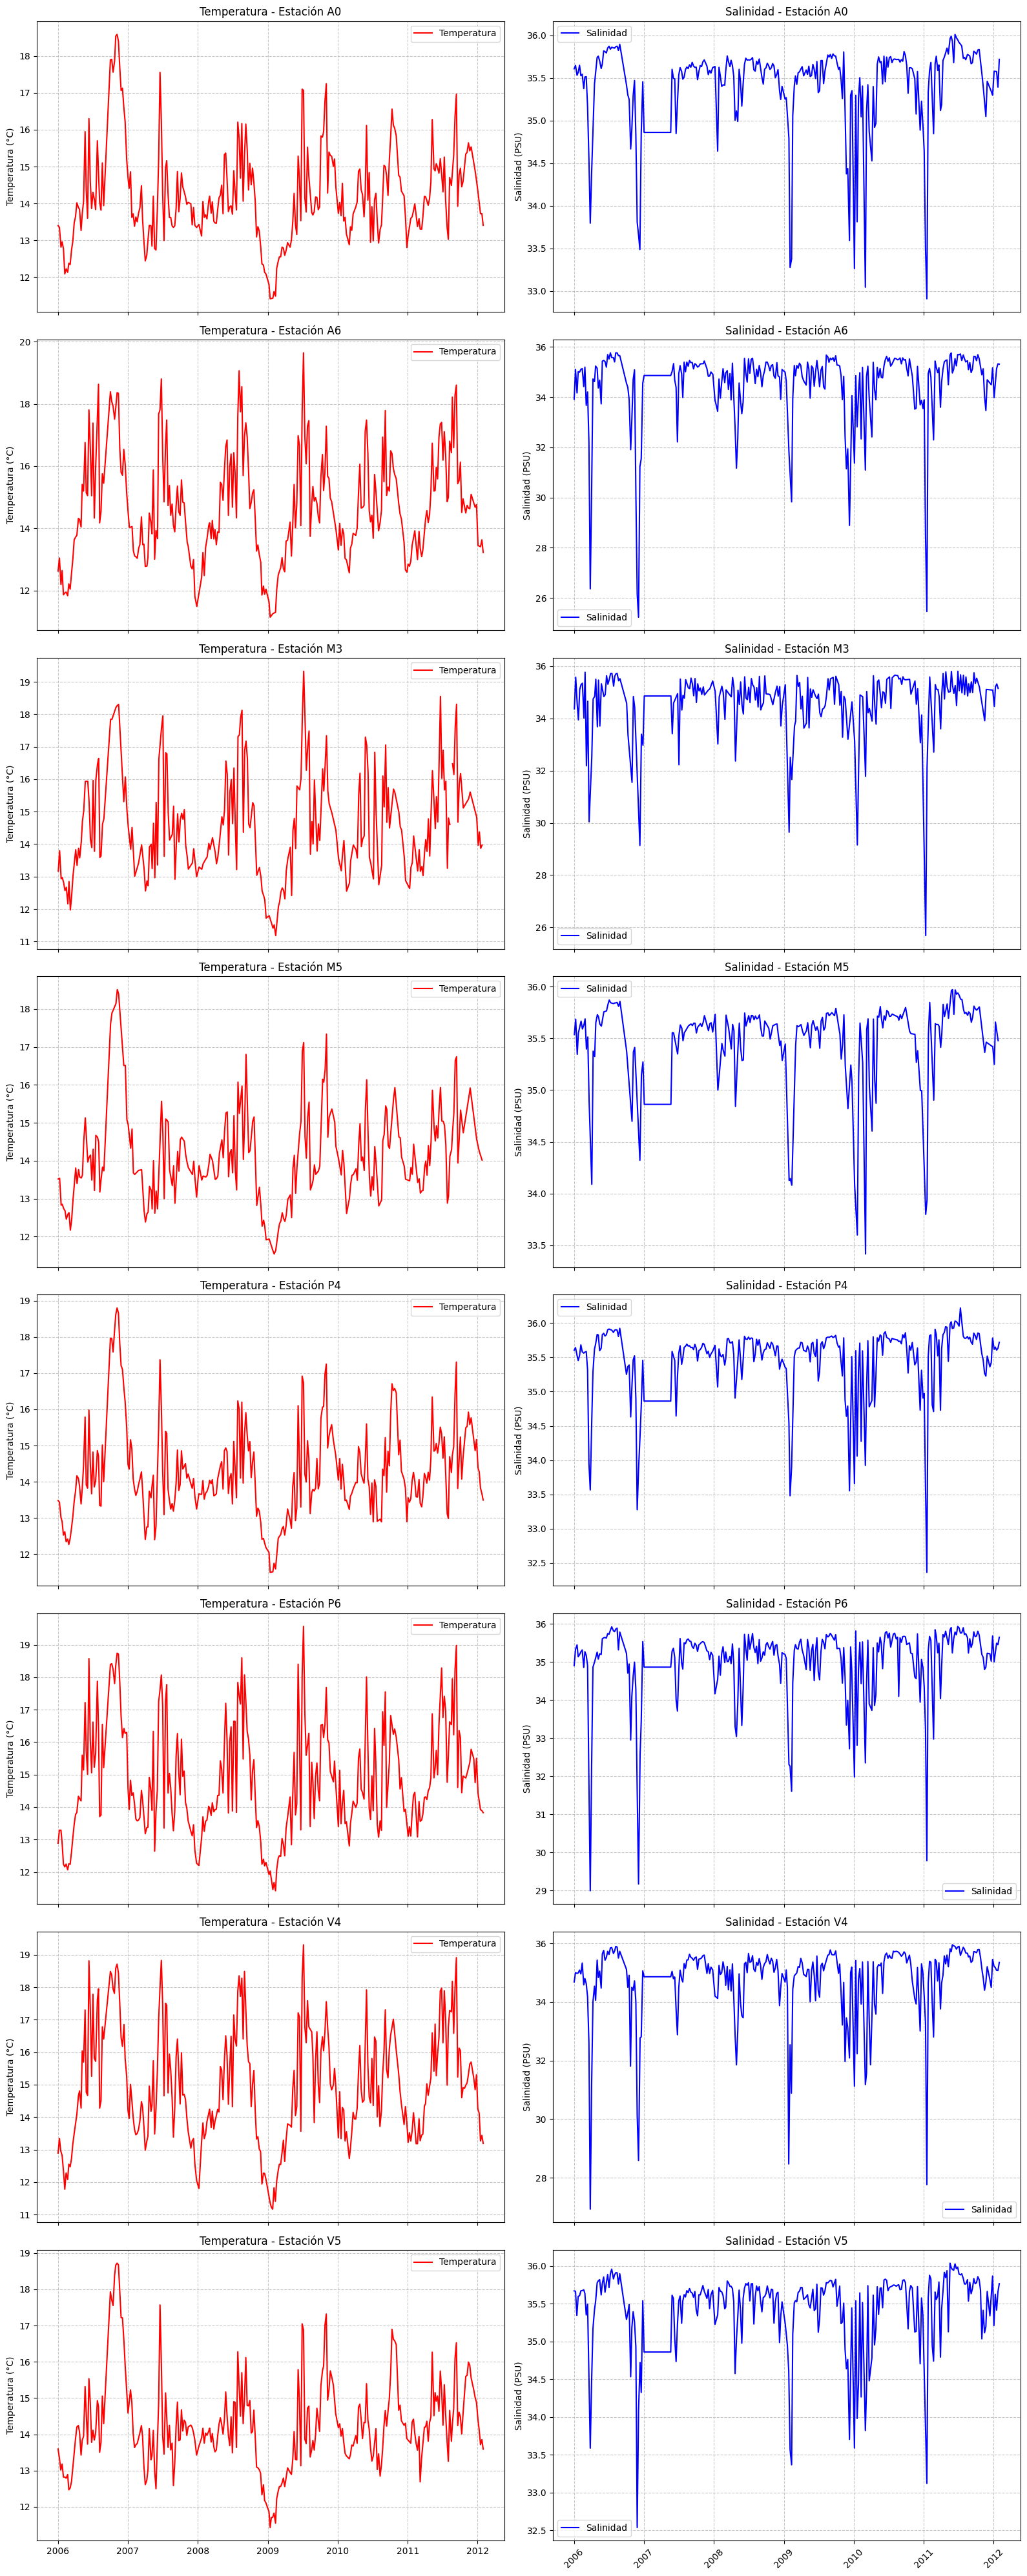

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurar que FECHA sea tipo datetime
ts_2002_2012["FECHA"] = pd.to_datetime(ts_2002_2012["FECHA"])

# Obtener lista de estaciones únicas
stations = ts_2002_2012["STATION"].unique()

# Crear figura con subgráficos para cada estación
fig, axes = plt.subplots(len(stations), 2, figsize=(16, 5 * len(stations)), sharex=True)

# Si solo hay una estación, asegurar que axes sea un array bidimensional
if len(stations) == 1:
    axes = [axes]

# Iterar sobre cada estación y graficar los datos
for i, station in enumerate(stations):
    # Filtrar los datos por estación
    data_station = ts_2002_2012[ts_2002_2012["STATION"] == station]

    # Formatear eje X para mostrar solo los años
    for ax in axes[i]:
        ax.xaxis.set_major_locator(mdates.YearLocator())  # Marcas cada año
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato Año

    # Gráfica de temperatura
    axes[i, 0].plot(data_station["FECHA"], data_station["TEMPERATURA"], color="red", label="Temperatura")
    axes[i, 0].set_title(f"Temperatura - Estación {station}")
    axes[i, 0].set_ylabel("Temperatura (°C)")
    axes[i, 0].legend()
    axes[i, 0].grid(True, linestyle="--", alpha=0.7)

    # Gráfica de salinidad
    axes[i, 1].plot(data_station["FECHA"], data_station["SALINIDAD"], color="blue", label="Salinidad")
    axes[i, 1].set_title(f"Salinidad - Estación {station}")
    axes[i, 1].set_ylabel("Salinidad (PSU)")
    axes[i, 1].legend()
    axes[i, 1].grid(True, linestyle="--", alpha=0.7)

# Ajustar diseño
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
ts_2002_2012.columns

Index(['STATION', 'FECHA', 'TEMPERATURA', 'SALINIDAD'], dtype='object')

In [14]:
pigmentos.head(1)

,INDEX,DATE,STATION,LAT,LONG,CHLA_Big_0_5,CHLA_Big_5_10,CHLA_Big_10_15,CHLA_Small_0_5,CHLA_Small_5_10,...,CHLB_Big_10_15,CHLB_Small_0_5,CHLB_Small_5_10,CHLB_Small_10_15,CHLC_Big_0_5,CHLC_Big_5_10,CHLC_Big_10_15,CHLC_Small_0_5,CHLC_Small_5_10,CHLC_Small_10_15
0,1,2002-01-02 00:00:00.000,V4,42.275,-8.685167,0.185,0.24,0.213,0.048,0.024,...,0.02,0.036,0.029,0.038,0.014,0.019,0.018,0.0,0.005,0.001


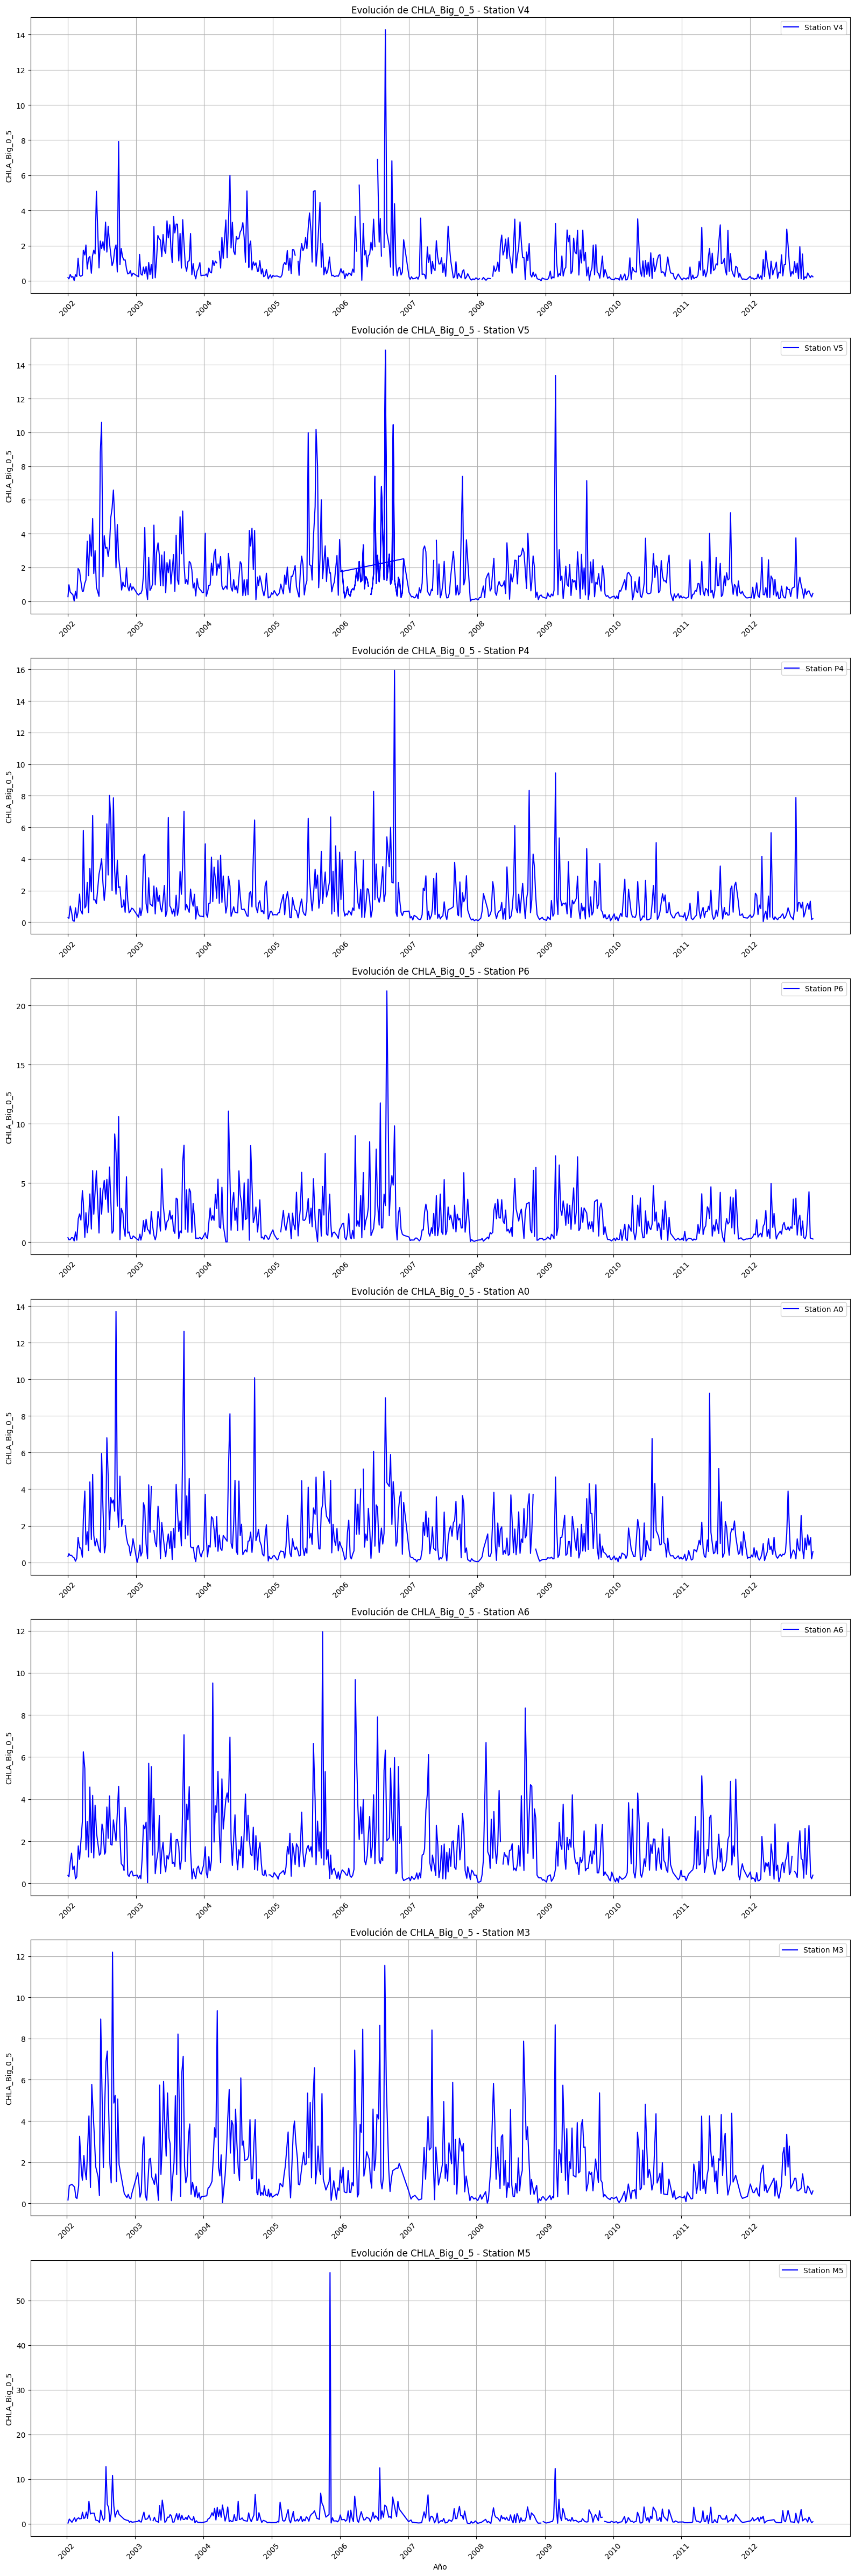

In [15]:
# Convertir la columna de fecha a formato datetime y extraer el año
pigmentos["FECHA"] = pd.to_datetime(pigmentos["DATE"])
pigmentos["AÑO"] = pigmentos["FECHA"].dt.year  # Extraer el año

# Calcular la media de CHLA_Big_0_5 por año y estación, ignorando valores negativos
media_por_año_estacion = (
    pigmentos[pigmentos["CHLA_Big_0_5"] >= 0]
    .groupby(["STATION", "AÑO"])["CHLA_Big_0_5"]
    .transform("mean")
)

# Reemplazar valores negativos con la media del mismo año y estación
pigmentos.loc[pigmentos["CHLA_Big_0_5"] < 0, "CHLA_Big_0_5"] = media_por_año_estacion

# Obtener las estaciones únicas
stations = pigmentos["STATION"].unique()

# Crear una figura con subgráficos (una gráfica lineal por estación)
fig, axes = plt.subplots(nrows=len(stations), figsize=(16, 6 * len(stations)), sharex=False)

# Asegurar que 'axes' sea una lista si solo hay una estación
if len(stations) == 1:
    axes = [axes]

# Graficar cada estación en su propio subplot
for ax, station in zip(axes, stations):
    datos_estacion = pigmentos[pigmentos["STATION"] == station]

    # Graficar línea sin agrupar por año
    ax.plot(datos_estacion["FECHA"], datos_estacion["CHLA_Big_0_5"], linestyle="-", color="b", linewidth=1.5, label=f"Station {station}")

    # Configurar los ticks del eje X con los años únicos en cada subplot
    años_unicos = sorted(datos_estacion["AÑO"].unique())
    ax.set_xticks([pd.Timestamp(f"{año}-01-01") for año in años_unicos])  # Convertir años a formato de fecha
    ax.set_xticklabels(años_unicos, rotation=45)  

    ax.set_title(f"Evolución de CHLA_Big_0_5 - Station {station}")
    ax.set_ylabel("CHLA_Big_0_5")
    ax.legend()
    ax.grid(True)

# Etiqueta común para el eje X en el último subplot
axes[-1].set_xlabel("Año")

# Ajustar diseño
plt.tight_layout()
plt.show()

In [16]:
pigmentos.head(1)

,INDEX,DATE,STATION,LAT,LONG,CHLA_Big_0_5,CHLA_Big_5_10,CHLA_Big_10_15,CHLA_Small_0_5,CHLA_Small_5_10,...,CHLB_Small_5_10,CHLB_Small_10_15,CHLC_Big_0_5,CHLC_Big_5_10,CHLC_Big_10_15,CHLC_Small_0_5,CHLC_Small_5_10,CHLC_Small_10_15,FECHA,AÑO
0,1,2002-01-02 00:00:00.000,V4,42.275,-8.685167,0.185,0.24,0.213,0.048,0.024,...,0.029,0.038,0.014,0.019,0.018,0.0,0.005,0.001,2002-01-02,2002


In [17]:
pigmentos.shape

(4259, 25)

In [18]:
ts_2002_2012.head(5)

,STATION,FECHA,TEMPERATURA,SALINIDAD
0,A0,2006-01-02,13.400782,35.608330
1,A0,2006-01-09,13.353843,35.648164
2,A0,2006-01-17,12.816960,35.532549
3,A0,2006-01-23,12.961577,35.566859
4,A0,2006-01-30,12.775529,35.650120


In [19]:
# Eliminar duplicados manteniendo solo la primera aparición
ts_2002_2012 = ts_2002_2012.drop_duplicates(subset=["STATION", "FECHA"], keep="first")

# Mostrar las primeras filas para verificar
print(ts_2002_2012.head())

  STATION      FECHA  TEMPERATURA  SALINIDAD
0      A0 2006-01-02    13.400782  35.608330
1      A0 2006-01-09    13.353843  35.648164
2      A0 2006-01-17    12.816960  35.532549
3      A0 2006-01-23    12.961577  35.566859
4      A0 2006-01-30    12.775529  35.650120


In [20]:
ts_2002_2012.shape

(2286, 4)

In [21]:
pigmentos.drop(columns=['INDEX','DATE','LAT', 'LONG','AÑO'], inplace=True)
# Renombrar las columnas
ts_2002_2012 = ts_2002_2012.rename(columns={"Código": "STATION", "Fecha": "FECHA"})

In [22]:
pigmentos.head(5)

,STATION,CHLA_Big_0_5,CHLA_Big_5_10,CHLA_Big_10_15,CHLA_Small_0_5,CHLA_Small_5_10,CHLA_Small_10_15,CHLB_Big_0_5,CHLB_Big_5_10,CHLB_Big_10_15,CHLB_Small_0_5,CHLB_Small_5_10,CHLB_Small_10_15,CHLC_Big_0_5,CHLC_Big_5_10,CHLC_Big_10_15,CHLC_Small_0_5,CHLC_Small_5_10,CHLC_Small_10_15,FECHA
0,V4,0.185,0.240,0.213,0.048,0.024,0.060,0.018,0.016,0.020,0.036,0.029,0.038,0.014,0.019,0.018,0.000,0.005,0.001,2002-01-02
1,V4,0.109,0.109,0.089,0.048,0.042,0.060,0.019,0.017,0.023,0.045,0.039,0.046,0.008,0.010,0.008,0.003,0.002,0.000,2002-01-07
2,V4,0.359,0.330,0.331,0.097,0.113,0.113,0.024,0.009,0.002,0.049,0.055,0.055,0.018,0.021,0.026,-0.006,-0.007,-0.007,2002-01-14
3,V4,0.198,0.333,0.330,0.075,0.080,0.067,0.021,0.010,0.013,0.054,0.054,0.045,0.020,0.030,0.024,-0.005,-0.004,-0.001,2002-01-21
4,V4,0.243,0.007,0.236,0.029,0.244,0.053,0.012,0.030,0.015,0.034,0.024,0.029,0.018,0.006,0.014,0.003,0.015,0.004,2002-01-28


In [23]:
# Asegurar que FECHA sea tipo datetime en ambos DataFrames
ts_2002_2012["FECHA"] = pd.to_datetime(ts_2002_2012["FECHA"])
pigmentos["FECHA"] = pd.to_datetime(pigmentos["FECHA"])

# Fusionar los DataFrames en base a FECHA y STATION
df_merged = pd.merge(ts_2002_2012, pigmentos, on=["FECHA", "STATION"], how="inner")

# Mostrar las primeras filas del DataFrame fusionado
print(df_merged.head(1))

  STATION      FECHA  TEMPERATURA  SALINIDAD  CHLA_Big_0_5  CHLA_Big_5_10  \
0      A0 2006-01-02    13.400782   35.60833           0.9           0.66   

   CHLA_Big_10_15  CHLA_Small_0_5  CHLA_Small_5_10  CHLA_Small_10_15  ...  \
0            0.55           0.033            0.087              0.11  ...   

   CHLB_Big_10_15  CHLB_Small_0_5  CHLB_Small_5_10  CHLB_Small_10_15  \
0           0.021           0.024            0.039             0.059   

   CHLC_Big_0_5  CHLC_Big_5_10  CHLC_Big_10_15  CHLC_Small_0_5  \
0         0.088          0.068           0.048           0.011   

   CHLC_Small_5_10  CHLC_Small_10_15  
0            0.015             0.013  

[1 rows x 22 columns]


In [24]:
df_merged.shape

(2248, 22)

In [25]:
df_merged = df_merged.drop(columns=[
       'CHLA_Big_5_10', 'CHLA_Big_10_15', 'CHLA_Small_0_5', 'CHLA_Small_5_10',
       'CHLA_Small_10_15', 'CHLB_Big_0_5', 'CHLB_Big_5_10', 'CHLB_Big_10_15',
       'CHLB_Small_0_5', 'CHLB_Small_5_10', 'CHLB_Small_10_15', 'CHLC_Big_0_5',
       'CHLC_Big_5_10', 'CHLC_Big_10_15', 'CHLC_Small_0_5', 'CHLC_Small_5_10',
       'CHLC_Small_10_15'])
df_merged.columns

Index(['STATION', 'FECHA', 'TEMPERATURA', 'SALINIDAD', 'CHLA_Big_0_5'], dtype='object')

In [26]:
df_merged.isna().sum()

STATION          0
FECHA            0
TEMPERATURA      1
SALINIDAD        0
CHLA_Big_0_5    13
dtype: int64

In [27]:
df_merged.head(1)

,STATION,FECHA,TEMPERATURA,SALINIDAD,CHLA_Big_0_5
0,A0,2006-01-02,13.400782,35.60833,0.9


In [28]:
# Eliminar espacios en los nombres de las columnas
afloramiento.columns = afloramiento.columns.str.strip()

# Renombrar columnas para que pandas las reconozca
afloramiento = afloramiento.rename(columns={"Ano": "year", "Mes": "month", "Dia": "day"})

# Convertir a tipo numérico (por si están como texto)
afloramiento["year"] = pd.to_numeric(afloramiento["year"], errors="coerce")
afloramiento["month"] = pd.to_numeric(afloramiento["month"], errors="coerce")
afloramiento["day"] = pd.to_numeric(afloramiento["day"], errors="coerce")

# Eliminar filas con valores NaN en year, month o day
afloramiento = afloramiento.dropna(subset=["year", "month", "day"])

# Crear la columna FECHA
afloramiento["FECHA"] = pd.to_datetime(afloramiento[["year", "month", "day"]])

# Seleccionar solo las columnas FECHA y UI
afloramiento = afloramiento[["FECHA", "UI"]]

# Mostrar las primeras filas para verificar
print(afloramiento.head())

       FECHA      UI
0 1967-01-01 -708.84
1 1967-01-01 -708.84
2 1967-01-01   52.93
3 1967-01-01 -196.60
4 1967-01-02 -196.60


In [29]:
# Filtrar las fechas entre 2002-01-01 y 2012-12-31
afloramiento = afloramiento[afloramiento["FECHA"].between("2002-01-01", "2012-12-31")]

In [30]:
afloramiento = afloramiento.drop_duplicates(subset=["FECHA"], keep="first")
afloramiento.head(-2)

,FECHA,UI
51136,2002-01-01,-1730.80
51140,2002-01-02,-4189.40
51144,2002-01-03,-708.91
51148,2002-01-04,-362.79
51152,2002-01-05,-681.85
...,...,...
67168,2012-12-24,-3802.30
67172,2012-12-25,-140.80
67176,2012-12-26,52.93
67180,2012-12-27,-708.91


In [31]:
for i in range(1,5):
    afloramiento[f"UI_{i}"] = afloramiento["UI"].shift(i)

In [32]:
afloramiento.head()

,FECHA,UI,UI_1,UI_2,UI_3,UI_4
51136,2002-01-01,-1730.80,NaN,NaN,NaN,NaN
51140,2002-01-02,-4189.40,-1730.80,NaN,NaN,NaN
51144,2002-01-03,-708.91,-4189.40,-1730.80,NaN,NaN
51148,2002-01-04,-362.79,-708.91,-4189.40,-1730.8,NaN
51152,2002-01-05,-681.85,-362.79,-708.91,-4189.4,-1730.8


In [33]:
df_merged.head(1)

,STATION,FECHA,TEMPERATURA,SALINIDAD,CHLA_Big_0_5
0,A0,2006-01-02,13.400782,35.60833,0.9


In [34]:
df_merged = df_merged.merge(afloramiento, on="FECHA", how="left")
df_merged.shape

(2248, 10)

In [35]:
df_merged.head(1)

,STATION,FECHA,TEMPERATURA,SALINIDAD,CHLA_Big_0_5,UI,UI_1,UI_2,UI_3,UI_4
0,A0,2006-01-02,13.400782,35.60833,0.9,255.9,-594.97,-310.83,94.356,841.95


In [36]:
nutrientes.head(1)

,FECHA,PUNTO,fosfato,nitrato,nitrito,silicato,Unnamed: 6,NOTAS,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2002-01-02,A0,0.506667,3.033333,1.016667,1.19,NaN,"1. Datos de fosfato,nitrato, nitrito, y silica...",NaN,NaN,NaN,NaN,NaN


In [37]:
nutrientes = nutrientes[["FECHA", "PUNTO", "nitrato", "nitrito", "silicato", "fosfato"]]
nutrientes = nutrientes.rename(columns={"PUNTO": "STATION"})  # Renombrar "PUNTO" a "STATION"
nutrientes.columns = nutrientes.columns.str.upper()  # Convertir todos los nombres de columna a mayúsculas
nutrientes.head(1)

,FECHA,STATION,NITRATO,NITRITO,SILICATO,FOSFATO
0,2002-01-02,A0,3.033333,1.016667,1.19,0.506667
